In [45]:
import pandas as pd
import math
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from MEBF import MEBF, matrix_subtract, matrix_product
import seaborn as sns
import time
from scipy import stats
%matplotlib inline
from numba import jit
import warnings

In [46]:
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True,formatter={'float_kind':'{:.6f}'.format})

In [2]:
data = pd.read_csv("../data/gse.csv",index_col = 0)

# Boolean Matrix Factorization

In [3]:
x_in_paper = pd.DataFrame(np.array([[1,1,0,1,1,1,0,1,0,0,0],[1,1,1,1,1,1,1,1,1,1,1],[1,1,0,1,1,1,1,0,1,0,1],
         [0,1,0,0,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,0,0],[1,1,1,1,1,1,1,0,1,0,0],
         [0,0,0,1,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,1,0],[1,1,0,1,0,1,1,0,0,0,0],
         [1,1,1,1,1,0,0,0,0,0,0,],[1,1,0,1,1,0,0,0,0,0,0]]), index = range(1,12), columns = range(1,12))
A,B = MEBF(x_in_paper,0.8)

<AxesSubplot:>

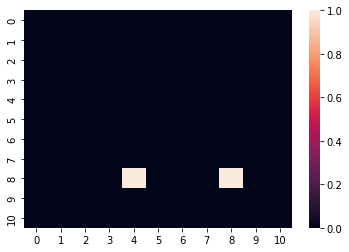

In [4]:
sns.heatmap(matrix_subtract(x_in_paper.values, matrix_product(A.values, B.values)), annot=False, vmin=0, vmax=1)

# BCV

### set iteration = 30

In [95]:
@jit
def bcv(data,times=20, num_comps=20, r=5, s=5):
    """
    parameter:
        data: 
            input data
            dropped rows and cols with all 0's
            scale not required
        times:
            iteration number of each number of components
        num_compons:
            total number of components
        r:
            the first shape of leave-out submatrix
        s:
            the second shape of leave-out submatrix
    
    function:
        leave out a submatrix A of shape (r,s)
        perform pca with number of components from [1, num_comps] with iteration equal to times
        perform bcv to compute A', and its error
    
    return:
        error, under components and iterations
        1-q2_A, the variance of 1 - var(A-A')/var(A), indicates how good A could be predicted      
    """
    # times = 15
    # num_comps = 25
    x = pd.DataFrame(scale(data),index = data.index, columns = data.columns)
    error = pd.DataFrame(index = range(1,times+1), columns = range(1,num_comps+1))
    var_A = pd.DataFrame(index = range(1,times+1), columns = range(1,num_comps+1))
    # iterate over number of components
    for num in range(1,num_comps+1):
        for time in range(1,times+1):
            # shuffle x
            x = x[np.random.permutation(x.columns)]
            x = x.reindex(np.random.permutation(x.index))
            # leave out submatrix
            A = x.values[:r,:s]
            B = x.values[:r,s:]
            C = x.values[r:,:s]
            D = x.values[r:,s:]
            # perform PCA
            pca = PCA(n_components = num)
            pca.fit(D)
            pca_df = pca.transform(D)
            D_approx = pca.inverse_transform(pca_df)
            A_approx = np.dot( np.dot(B,np.linalg.pinv(D_approx)), C)
            residule = A_approx - A
            """
            if (sum(np.abs(residule)).sum() > 10000):
                error.loc[time][num] = 500
            else: 
                error.loc[time][num] = sum(np.abs(residule)).sum()
            """
            error.loc[time][num] = sum(np.abs(residule)).sum()
            var_A.loc[time][num] = np.var(residule) / np.var(A)
    q2_A = pd.DataFrame(np.array(np.mean(var_A)).reshape(1,-1),columns = var_A.columns)
    q2_A = 1 - q2_A
    q2_A[q2_A < 0] = 0
    return error,  q2_A

## Personally, I prefer 5%

In [61]:
# preprocess on data
# first, drop rows and cols with all 0s
pre = data.copy()
# pre = pre.loc[(pre!=0).any(axis=1)]
# pre = pre.loc[:,(pre!= 0).any(axis=0)]

In [62]:
# choose rows and columns with least 0's
pre[pre!=0] = 1
idx = pre.eq(1).sum(axis=1).sort_values(ascending=False).index
pre = pre.reindex(idx)
cols = pre.eq(1).sum(axis=0).sort_values(ascending=False).index
pre = pre[cols]

In [83]:
# choose 1000 x 1000 left-upper corner submatrix
gse = np.log2(data+1).copy()
gse = gse[pre.columns[0:1000]]
gse = gse.loc[pre.index[0:1000]]

In [88]:
times = 30
num_comps = 20
#error_t,  q2_A = bcv(gse,times,num_comps,round(gse.shape[0]*0.05),round(gse.shape[1]*0.05))
error_t,  q2_A = bcv(gse,times,num_comps,10,10)

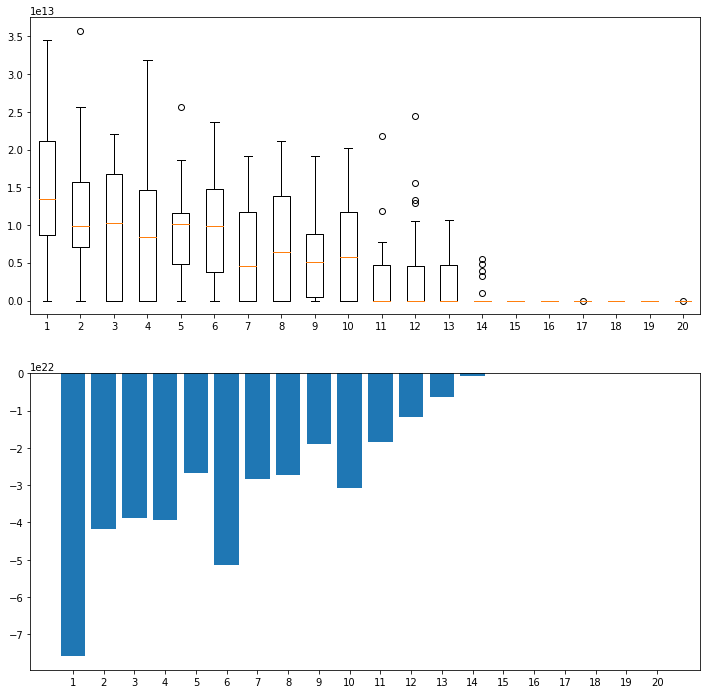

In [89]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(np.arange(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

In [90]:
q2_A

1             2             3             4             5   \
0 -7.571067e+22 -4.184921e+22 -3.867008e+22 -3.941794e+22 -2.663915e+22   

             6             7             8             9             10  \
0 -5.148338e+22 -2.840988e+22 -2.717424e+22 -1.907520e+22 -3.088045e+22   

             11            12            13            14      15        16  \
0 -1.839524e+22 -1.169484e+22 -6.329405e+21 -7.392102e+20  0.8087  0.805182   

         17        18        19        20  
0  0.794828  0.797757  0.807439  0.826648

In [96]:
times = 30
num_comps = 20
#error_t,  q2_A = bcv(gse,times,num_comps,round(gse.shape[0]*0.05),round(gse.shape[1]*0.05))
error_t,  q2_A = bcv(gse,times,num_comps,10,10)

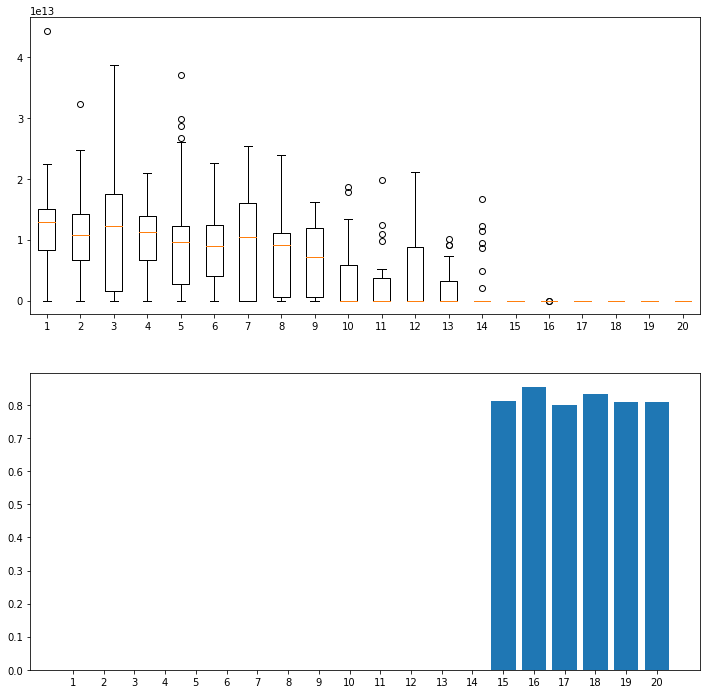

In [97]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(np.arange(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

In [98]:
q2_A

1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

         15       16        17        18        19        20  
0  0.812497  0.85333  0.800174  0.833102  0.809858  0.809946

In [99]:
times = 30
num_comps = 20
error_t,  q2_A = bcv(gse,times,num_comps,round(gse.shape[0]*0.05),round(gse.shape[1]*0.05))
# error_t,  q2_A = bcv(gse,times,num_comps,10,10)

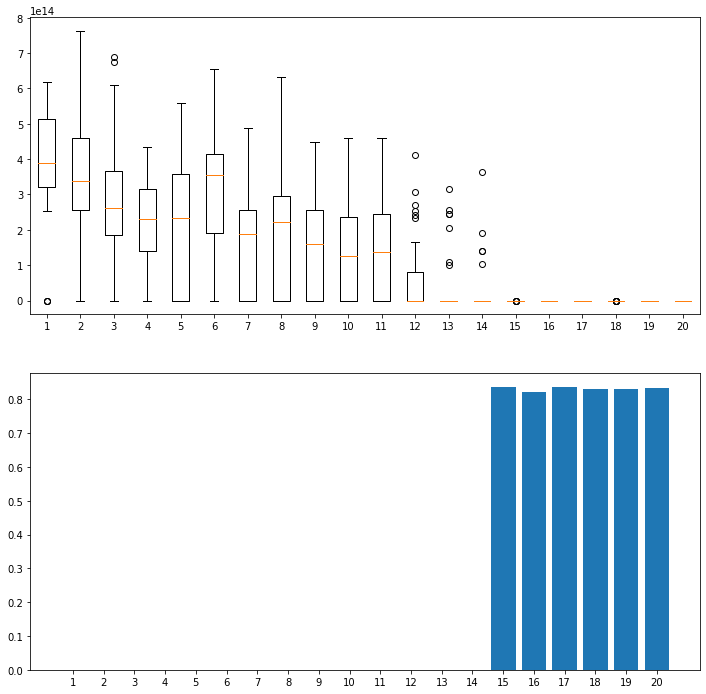

In [100]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(np.arange(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

In [102]:
error_t

1                      2                       3   \
1              792.802674   331790103780486.4375       335852899432567.0   
2      565530342975024.75             781.240194     334358092295592.875   
3    483529751954307.1875     528406714345557.25       462990037565272.5   
4     389165026331229.375      411026090202998.0  129021310761437.046875   
5              809.106782             711.556678   272349632015929.65625   
6      619106908373960.25  184846504233508.65625              791.021546   
7    252198393845138.5625    253729642944955.375     689493252177045.375   
8    380154221329298.6875   285899550137668.0625     513344993191168.375   
9    474165706619999.1875   466392582885365.1875      182810309235714.25   
10   473813864008398.4375   387866776670874.1875              816.613042   
11   459035652424577.9375   282879316256854.1875      610317292893901.25   
12     543405392135602.25   508251123689924.8125     288630836958991.375   
13    591113056107259.125      401124636348855.0     320890765908012.875   
14     319282952013430.25     473165346202800.25       674108524704151.0   
15     610296178266362.75             806.685884              750.298645   
16   382151870587752.8125      417822532449202.0              749.267348   
17    508699256090413.125   346840915559930.1875   239579924537385.21875   
18   464736338672627.1875    635007185894414.625       481781814857971.0   
19   390636318881347.1875   321322539907472.5625              829.506711   
20    616633991913096.375             976.203004   253640428101859.21875   
21   353254177183389.9375   310389929267679.6875      399350148883875.75   
22   384816581104774.3125   442801229454070.6875   205726198907857.59375   
23   289234285543763.8125      762759179001209.5       220507873271730.5   
24     515458230801686.25  144880410169379.40625     218015921921181.625   
25   271824007205498.5625               843.5548              776.241309   
26             829.407261   377150101669454.1875     195598856087487.125   
27  281088642524073.59375      708256278864725.0    346260169733811.0625   
28    595604725869718.375   275529994817485.6875      292225187276606.75   
29    322920900176669.375     672499327382729.25      372821191997104.75   
30   331307235802045.6875   263314034984089.1875      245322627441588.25   

                       4                      5                      6   \
1    245667660643305.9375    316478116203614.125   506793189558711.9375   
2              759.016182     424933047944166.25             748.034628   
3    407338289086348.0625      438461001550721.5             743.336234   
4    317233092285175.9375             788.013763   307260030486339.6875   
5    433828703431574.0625    266289187704640.375             723.975089   
6   229414368792479.46875             788.050918   173611904737749.6875   
7   141884614215661.15625    319413485164538.125   363508349650643.4375   
8    208164556305716.8125    306684784298088.625   411935050124796.1875   
9    320265992524995.3125    517736569353216.375    351890593055238.125   
10    307241962477501.625  202568376789287.90625   486077355101014.0625   
11     216637656085398.75              805.54915  251164267055381.96875   
12   117202244413007.8125     420894742329531.25             599.697643   
13  241189293486883.90625  127869402060220.15625   370340355168888.9375   
14              815.63707              730.72522   414195819913517.9375   
15   230404841238569.8125   337134078835009.1875    360340540368332.375   
16  138251279569705.96875             774.840717      653888551677440.0   
17  239562576943543.09375   154180565056488.0625    523085494805124.375   
18   408521942224562.0625   293528900407427.4375   405564183544884.6875   
19             776.153186             896.088267     328289732277874.25   
20             807.034383    288495218129864.125    434955254340054.125   
21     274406750077192.75             847.965113    206959698190953.125   
22             8

In [105]:
for i in range(1,num_comps):
    print("Huge difference between ",i, i+1, 
          (stats.ttest_ind(error_t[i],error_t[i+1], equal_var = False).pvalue <= 0.1))

Huge difference between  1 2 False
Huge difference between  2 3 False
Huge difference between  3 4 False
Huge difference between  4 5 False
Huge difference between  5 6 True
Huge difference between  6 7 True
Huge difference between  7 8 False
Huge difference between  8 9 False
Huge difference between  9 10 False
Huge difference between  10 11 False
Huge difference between  11 12 True
Huge difference between  12 13 False
Huge difference between  13 14 False
Huge difference between  14 15 True
Huge difference between  15 16 False
Huge difference between  16 17 False
Huge difference between  17 18 False
Huge difference between  18 19 False
Huge difference between  19 20 False


In [26]:
    x = pd.DataFrame(scale(gse),index = gse.index, columns = gse.columns)
    error = pd.DataFrame(index = range(1,times+1), columns = range(1,num_comps+1))
    var_A = pd.DataFrame(index = range(1,times+1), columns = range(1,num_comps+1))

In [27]:
x = x[np.random.permutation(x.columns)]
x = x.reindex(np.random.permutation(x.index))
A = x.values[:r,:s]
B = x.values[:r,s:]
C = x.values[r:,:s]
D = x.values[r:,s:]

In [31]:
pca = PCA(n_components = 1)
pca.fit(D)
pca_df = pca.transform(D)
D_approx = pca.inverse_transform(pca_df)
A_approx = np.dot( np.dot(B,np.linalg.pinv(D_approx)), C)
residule = A_approx - A

In [ ]:
    x = pd.DataFrame(scale(gse),index = gse.index, columns = gse.columns)
    error = pd.DataFrame(index = range(1,times+1), columns = range(1,num_comps+1))
    var_A = pd.DataFrame(index = range(1,times+1), columns = range(1,num_comps+1))
    # iterate over number of components
    for num in range(1,num_comps+1):
        for time in range(1,times+1):
            # shuffle x
            x = x[np.random.permutation(x.columns)]
            x = x.reindex(np.random.permutation(x.index))
            # leave out submatrix
            A = x.values[:r,:s]
            B = x.values[:r,s:]
            C = x.values[r:,:s]
            D = x.values[r:,s:]
            # perform PCA
            pca = PCA(n_components = num)
            pca.fit(D)
            pca_df = pca.transform(D)
            D_approx = pca.inverse_transform(pca_df)
            A_approx = np.dot( np.dot(B,np.linalg.pinv(D_approx)), C)
            residule = A_approx - A
            """
            if (sum(np.abs(residule)).sum() > 10000):
                error.loc[time][num] = 500
            else: 
                error.loc[time][num] = sum(np.abs(residule)).sum()
            """
            error.loc[time][num] = sum(np.abs(residule)).sum()
            var_A.loc[time][num] = np.var(residule) / np.var(A)
    # var_A[var_A>1] = 1
    q2_A = pd.DataFrame(np.array(np.mean(var_A)).reshape(1,-1),columns = var_A.columns)
    return error,  1-q2_A

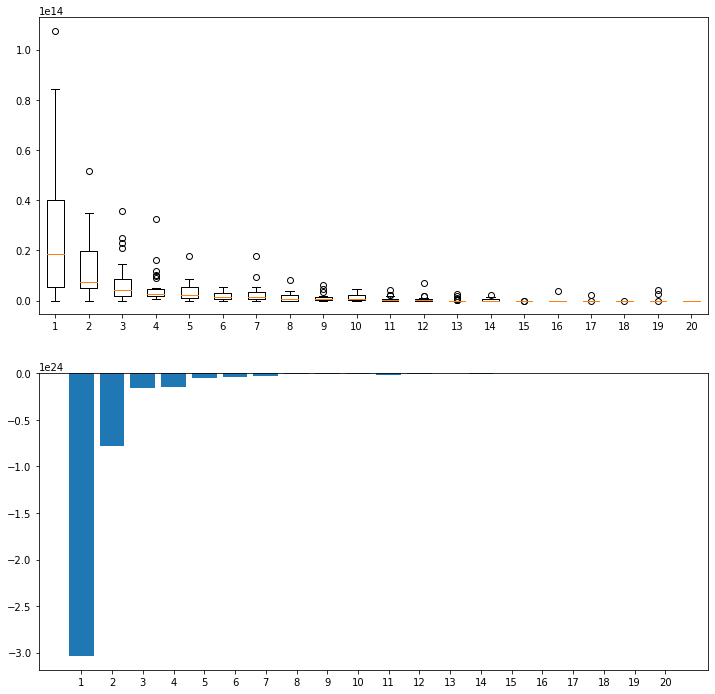

In [16]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(np.arange(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

In [30]:
times = 30
num_comps = 30
error_t,  q2_A = bcv(gse,times,num_comps,round(gse.shape[0]*0.05),round(gse.shape[1]*0.05))

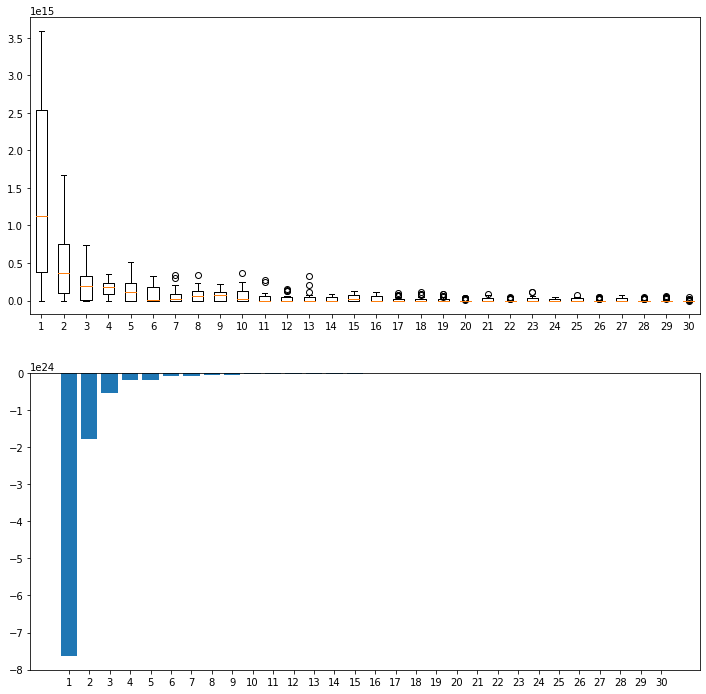

In [31]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(range(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

In [32]:
q2_A

1             2             3             4             5   \
0 -7.625707e+24 -1.786223e+24 -5.301544e+23 -1.784013e+23 -1.914859e+23   

             6             7             8             9             10  ...  \
0 -8.056731e+22 -7.485314e+22 -4.513618e+22 -3.582739e+22 -2.186320e+22  ...   

             21            22            23            24            25  \
0 -3.788994e+21 -1.001779e+21 -3.091408e+21 -1.598927e+21 -1.655939e+21   

             26            27            28            29            30  
0 -1.263892e+21 -2.833950e+21 -7.157344e+20 -6.530107e+20 -3.239641e+20  

[1 rows x 30 columns]

In [47]:
# try to work on 20 components

In [48]:
times = 30
num_comps = 20
error_t,  q2_A = bcv(pre,times,num_comps,round(pre.shape[0]*0.05),round(pre.shape[1]*0.05))

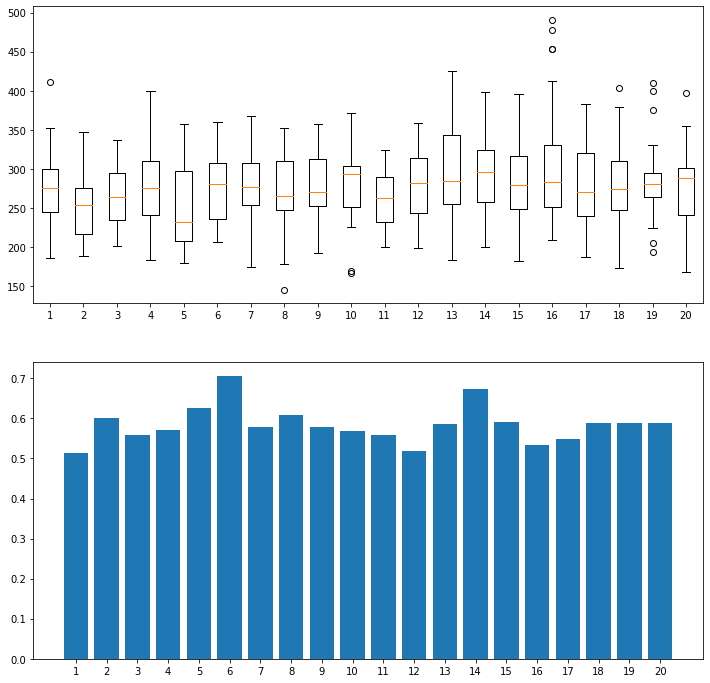

In [49]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.boxplot(error_t);
plt.subplot(2,1,2)
plt.bar(range(1,q2_A.shape[1]+1),list(q2_A.values.flatten()));
plt.xticks(np.arange(1,q2_A.shape[1]+1));

In [76]:
# filter condition: peak & > mean
q2_mean = q2_A.mean().mean()
candidate = []
for i in range(2,num_comps):
    if (q2_A[i-1] < q2_A[i]).all() and (q2_A[i] > q2_A[i+1]).all() and (q2_A[i]>q2_mean).all():
        candidate.append(i)

In [77]:
candidate

[2, 6, 8, 14, 19]

In [78]:
x = pd.DataFrame(scale(pre),index = pre.index, columns = pre.columns)

In [80]:
pca2 = PCA(n_components = 2)
pca2.fit(x)
pca_df2 = pca2.transform(x)
x_approx2 = pca2.inverse_transform(pca_df2)

In [81]:
pca6 = PCA(n_components = 6)
pca6.fit(x)
pca_df6 = pca6.transform(x)
x_approx6 = pca6.inverse_transform(pca_df6)

In [86]:
residule6 = x - x_approx6 # residule after pca6 fits x
residule2 = x - x_approx2 # residule after pca2 fits x

In [98]:
residule2.to_csv("res_2.csv")

In [103]:
up_bound = residule2.mean() + 3*residule2.std()
low_bound = residule2.mean() - 3*residule2.std()

In [121]:
t2 = residule2.copy()
t6 = residule6.copy()

In [122]:
t2[t2>=0.5] = 1
t2[t2<=-0.5] = 1
t2[t2!=1] = 0
t6[t6>=0.5] = 1
t6[t6<=-0.5] = 1
t6[t6!=1] = 0

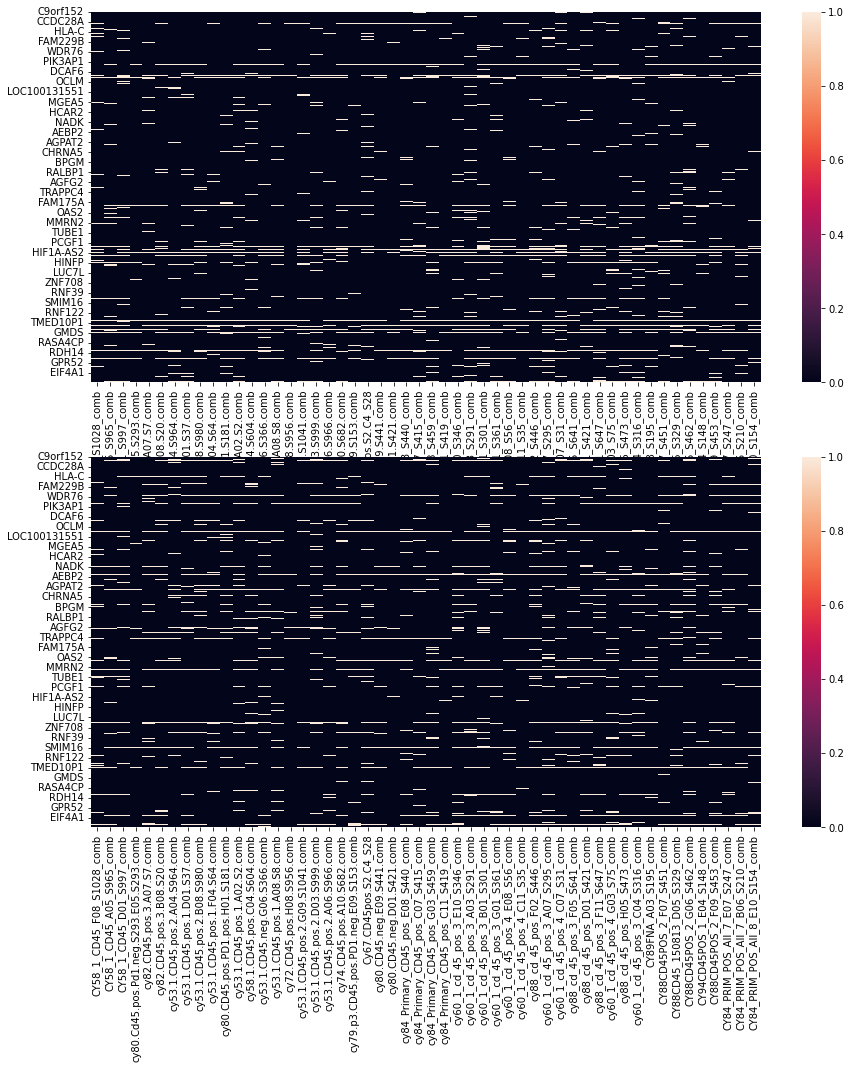

In [130]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
sns.heatmap(t2);
plt.subplot(2,1,2)
sns.heatmap(t6);

In [131]:
diff = np.abs(t2-t6)

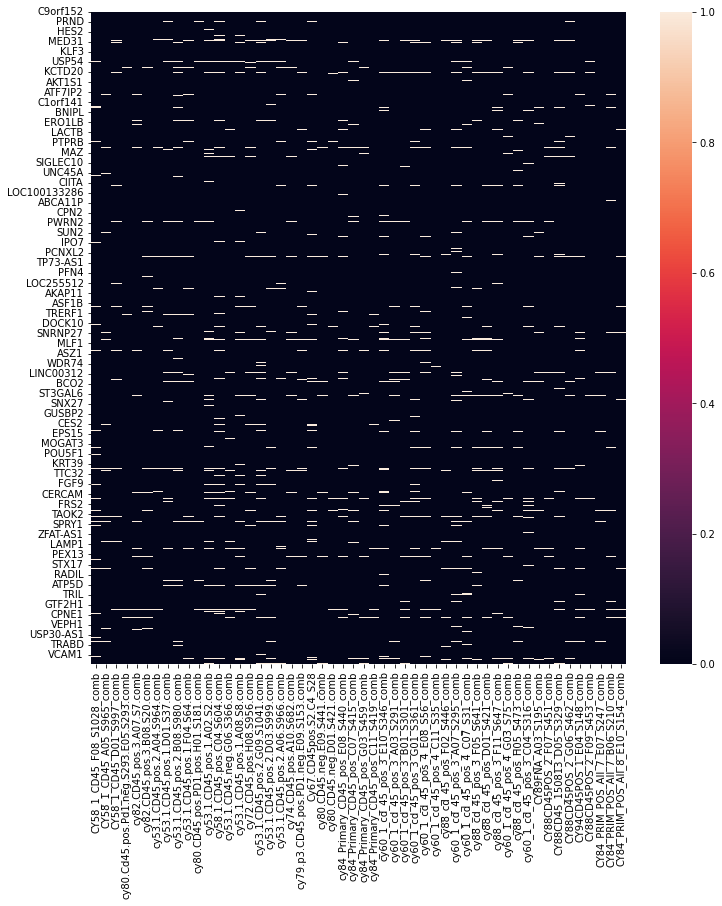

In [135]:
plt.figure(figsize=(12,12))
sns.heatmap(diff);

In [136]:
A,B = MEBF(diff,0.8)

<AxesSubplot:>

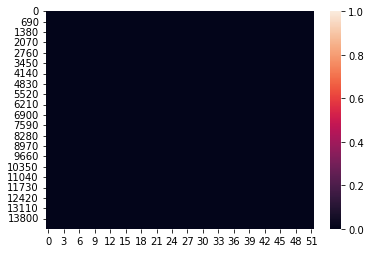

In [137]:
sns.heatmap(matrix_subtract(diff.values, matrix_product(A.values, B.values)), annot=False, vmin=0, vmax=1)

In [140]:
A,B = MEBF(diff,0.7)

<AxesSubplot:>

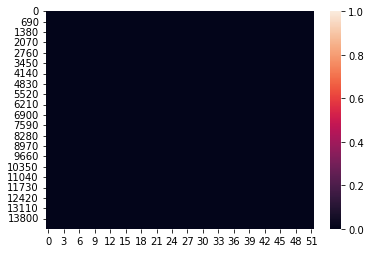

In [141]:
sns.heatmap(matrix_subtract(diff.values, matrix_product(A.values, B.values)), annot=False, vmin=0, vmax=1)